Building important functionalities of classic libraries like numpy, pytorch from ground up. \
Libraries / tools assumed:
1. Python and its standard library
2. Jupyter notebooks + nbdev
3. Matplotlib for plotting

In [1]:
import gzip, os, shutil, math, time, pickle, matplotlib.pyplot as plt, matplotlib as mpl
from pathlib import Path

In [2]:
MNIST_URL = 'https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true' # dataset used
path_data = Path('data')
print(path_data)

data


In [3]:
path_data.mkdir(exist_ok=True) # create a directory with the given name
path_gz = path_data / 'mnist.pkl.gz' # gz file with the mnist data

In [7]:
# we need a way to retrieve the mnist data from the URL - urlretrieve library helps us to do the same
from urllib.request import urlretrieve
if not path_gz.exists() : return_url = urlretrieve(MNIST_URL, path_gz)
print(return_url)


(PosixPath('data/mnist.pkl.gz'), <http.client.HTTPMessage object at 0x7962bbb386b0>)


In [8]:
with gzip.open(path_gz, 'rb') as f : mnist = pickle.load(f,encoding='latin-1')

In [11]:
train_data, valid_data, _ = mnist

In [12]:
x_train, y_train = train_data
x_val, y_val = valid_data
# print the shapes of the data
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(50000, 784) (50000,) (10000, 784) (10000,)


In [13]:
# inspect the first train image
train_img1 = list(x_train[0])
print(len(train_img1))

784


In [14]:
print(train_img1[200:210])

[np.float32(0.0), np.float32(0.0), np.float32(0.0), np.float32(0.19140625), np.float32(0.9296875), np.float32(0.98828125), np.float32(0.98828125), np.float32(0.98828125), np.float32(0.98828125), np.float32(0.98828125)]


In [15]:
# function to chunk the list into smaller parts and yield them like a iterator
def chunk(lst, n):
  for i in range(0, len(lst), n) : yield lst[i : i+n]

In [25]:
next(chunk(train_img1, 5)) # when you have an iterator , using next will fetch the elements in the current iteration of the iterator

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0)]

In [26]:
next(chunk(train_img1, 5))

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0)]

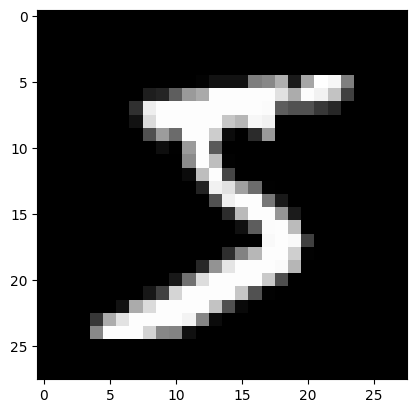

In [27]:
mpl.rcParams['image.cmap'] = 'gray'
# plot the first image resizing using chunk function
plt.imshow(list(chunk(train_img1, 28)))

In [28]:
from itertools import islice # very useful iterator tool for streaming data piece by piece

In [29]:
islice?

In [45]:
vals = train_img1[200:210]

In [46]:
vals

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.19140625),
 np.float32(0.9296875),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125),
 np.float32(0.98828125)]

In [47]:
it = iter(vals) # an iterable over values

In [48]:
val_iter = islice(it, 5) # collect 5 values from the iterator and then return them

In [49]:
list(val_iter)

[np.float32(0.0),
 np.float32(0.0),
 np.float32(0.0),
 np.float32(0.19140625),
 np.float32(0.9296875)]

In [51]:
list(val_iter)

[]

In [52]:
iter?


In [53]:
# split the original 784 long list into a matrix of size 28X28
it = iter(train_img1) # iterator over the image 1
img = list(iter(lambda : list(islice(it, 28)),[]))

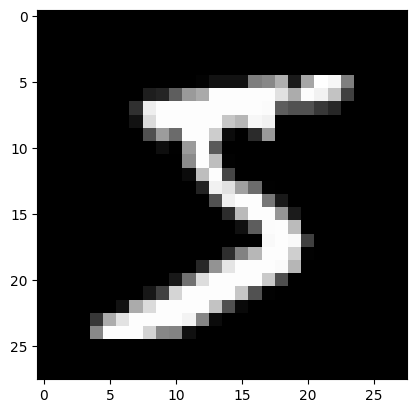

In [54]:
plt.imshow(img)

The way img was constructed above demands explanation. \
first of all the list train_img1 holds the 784 values describing the image in pixels. We create an iterator over that list, which will return the elements in that list one by one when next is called on that iterator

we pass that it to islice with 28 as stop limit, which means that it will start from current index and get 28 values from the current index and return each time it is called. This functionality is called as a callable to iter again with the sentinel i.e termination condition being [] i.e empty list

MATRIX AND TENSORS

In [55]:
len(img), len(img[0])

(28, 28)

In [57]:
# img is a 2D list.
img[20][10] # its values can be accessed this way

np.float32(0.09375)

In [58]:
# standard libraries support an alternate accessor -> img[a,b]
# implementation for the above accessor support
class Matrix:
  def __init__(self, xs) : self.xs = xs
  def __getitem__(self, idx) : return self.xs[idx[0]][idx[1]]

In the above code cell, Matrix is a class which may have many functions. the two functions are important functions with specific purposes. the functions which have __ (called dunders) have specific functionalities like acting as constructor, acting as accessors, setters, getters etc

In [59]:
m = Matrix(img)

In [60]:
m[20,10]

np.float32(0.09375)

We have achieved the functionality of accessing through m[a,b]

In [61]:
# we can wrap the creation of 2d lists from 1d lists and the accessor in the class
class Matrix:
  def __init__(self, lst, m, n):
    assert len(lst) == m*n
    self.lst = lst
    self.m, self.n = m, n
    it = iter(lst)
    self.mat = list(iter(lambda : list(islice(it, n)), []))

  def __getitem__(self, idx):
    return self.mat[idx[0]][idx[1]]


In [62]:
m = Matrix(train_img1, 28, 28)

In [64]:
m[20,10]

np.float32(0.09375)

In [65]:
# illustration of the same in pytorch
import torch
from torch import tensor

In [67]:
x_train, y_train, x_val, y_val = map(tensor, (x_train, y_train, x_val, y_val))

In [68]:
x_train.shape

torch.Size([50000, 784])

In [70]:
x_train = x_train.reshape(-1, 28,28)

In [73]:
x_train[0,20,10]

tensor(0.0938)

Playing around with Random Numbers

In [74]:
divmod?

In [87]:
#Wichmann Hill algorithm
rnd_state = None
def seed(a):
  global rnd_state # the global random variable is used inside function
  a, x = divmod(a, 30268)
  a, y = divmod(a, 30306)
  a, z = divmod(a, 30322)
  rnd_state = int(x) + 1, int(y) + 1, int(z) + 1

In [88]:
seed(9310847109182)

In [89]:
rnd_state

(26443, 7656, 10151)

In [90]:
# function to generate random number between 0 and 1
def rand():
  global rnd_state
  x,y,z = rnd_state
  x = (171 * x) % 30269
  y = (172 * y) % 30307
  z = (170 * z) % 30323
  rnd_state = x, y, z # here is where the randomization happens
  # rnd_state is updated here and the next time rand() gets called, this is used as input to further compute x, y, z
  return (x / 30269 +  y /  30307 + z / 30323) % 1.0

In [91]:
rand(), rnd_state

(0.7449796891269935, (11672, 13631, 27582))

In [92]:
rand(), rnd_state

(0.9316843523504539, (28427, 10893, 19198))

In [93]:
rand(), rnd_state

(0.04432939161206839, (17977, 24869, 19099))

In [97]:
if os.fork(): print(f'In parent: {rand()}')
else:
    print(f'In child: {rand()}')
    os._exit(os.EX_OK)

In parent: 0.3390084243896412


/tmp/ipython-input-2916155298.py:1: DeprecationWarning: This process (pid=629) is multi-threaded, use of fork() may lead to deadlocks in the child.
  if os.fork(): print(f'In parent: {rand()}')


In child: 0.3390084243896412

There are some subtleties associated with random number generation especially in deep learning where running algorithms on data parallely is often done. there are instances where a parent process runs algorithm on certain data and a child process runs algorithm on some other data and we may have to use rand() to choose different portion of data to run on child and parent process. but in our current implementation, if we call rand() on a child process called from forking parent process, we get same values.

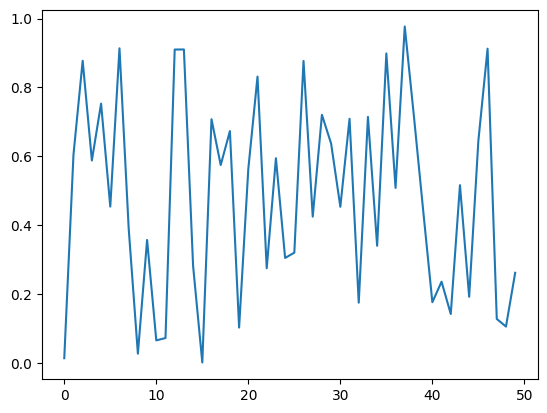

In [98]:

plt.plot([rand() for _ in range(50)]);


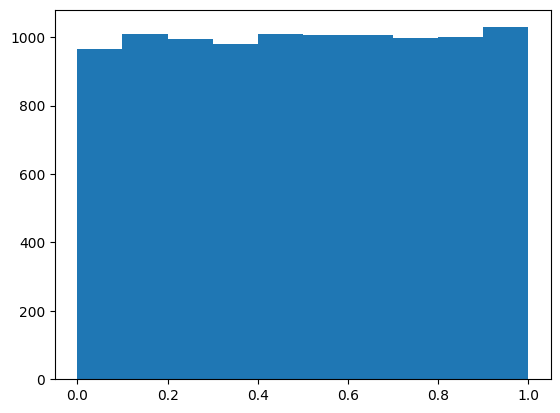

In [99]:
plt.hist([rand() for _ in range(10000)]);

This bug is present in pytorch and numpy as well

In [103]:
import numpy as np
if os.fork(): print(f'In parent: {np.random.uniform()}')
else:
    print(f'In child: {np.random.uniform()}')
    os._exit(os.EX_OK)

In parent: 0.21826361896113644


/tmp/ipython-input-546756631.py:2: DeprecationWarning: This process (pid=629) is multi-threaded, use of fork() may lead to deadlocks in the child.
  if os.fork(): print(f'In parent: {np.random.uniform()}')


In child: 0.21826361896113644


In [106]:
import numpy as np
if os.fork(): print(f'In parent: {torch.rand((1,))}')
else:
    print(f'In child: {torch.rand((1,))}')
    os._exit(os.EX_OK)

In parent: tensor([0.3257])


/tmp/ipython-input-1032426683.py:2: DeprecationWarning: This process (pid=629) is multi-threaded, use of fork() may lead to deadlocks in the child.
  if os.fork(): print(f'In parent: {torch.rand((1,))}')


In child: tensor([0.3257])

In [107]:
import random
if os.fork(): print(f'In parent: {random.random()}')
else:
    print(f'In child: {random.random()}')
    os._exit(os.EX_OK)

In parent: 0.6414161612668963


/tmp/ipython-input-628889825.py:2: DeprecationWarning: This process (pid=629) is multi-threaded, use of fork() may lead to deadlocks in the child.
  if os.fork(): print(f'In parent: {random.random()}')


In child: 0.5390271164053706